<a href="https://colab.research.google.com/github/monicafar147/unsupervised-predict-streamlit-template/blob/eda/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EDSA Movie Recommendation Challenge

This notebook was created to enter the private kaggle competition of EDSA on creating a movie recommendation predictor.

In today’s technology driven world, recommender systems are socially and economically critical for ensuring that individuals can make appropriate choices surrounding the content they engage with on a daily basis.

One application where this is especially true surrounds movie content recommendations; where intelligent algorithms can help viewers find great titles from tens of thousands of options.

This notebook will construct a recommendation algorithm based on content or collaborative filtering in order to accurately predict how a user will rate a movie they have not yet viewed based on their historical preferences.

Providing an accurate and robust solution to this challenge has immense economic potential, with users of the system being exposed to content they would like to view or purchase generating revenue and platform affinity.

# Imports

## Launching Comet Experiment

In [ ]:
# import comet_ml in the top of your file
from comet_ml import Experiment
    
# Add the following code anywhere in your machine learning file
experiment = Experiment(api_key="cFwBSBV5CDhaL3B3LHdwF7O3M",
                        project_name="recommender-systems", workspace="jonnybegreat")

## Importing modules

In [1]:
# Import essential packages
import pandas as pd
import numpy as np

# Import surprise packages
from surprise import BaselineOnly
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate

# Import models
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import SVD
from surprise.model_selection import GridSearchCV

# Import utilities
import os

## Importing the raw data

In [ ]:
imdb = pd.read_csv('imdb_data.csv')
train = pd.read_csv('train.csv',error_bad_lines=False)
genome_tags = pd.read_csv('genome_tags.csv')
movies = pd.read_csv('movies.csv')

In [8]:
# Importing train and test datasets
ratings_df = pd.read_csv('train.csv').drop(columns=['timestamp'],axis=0)
test_df = pd.read_csv('test.csv')
ratings_df.head()

,userId,movieId,rating
0,5163,57669,4.0
1,106343,5,4.5
2,146790,5459,5.0
3,106362,32296,2.0
4,9041,366,3.0


In [9]:
test_df.head()

,userId,movieId
0,1,2011
1,1,4144
2,1,5767
3,1,6711
4,1,7318


Due to the size of the data only a subset of the data was selected.

In [10]:
# Subset of test data
test_df_subset = test_df[:1000]

#EDA

In [5]:
data = pd.merge(train, movies, on='movieId')
data.head(5)

,userId,movieId,rating,timestamp,title,genres
0,5163,57669,4.0,1.518350e+09,In Bruges (2008),Comedy|Crime|Drama|Thriller
1,87388,57669,3.5,1.237455e+09,In Bruges (2008),Comedy|Crime|Drama|Thriller
2,137050,57669,4.0,1.425632e+09,In Bruges (2008),Comedy|Crime|Drama|Thriller
3,120490,57669,4.5,1.408229e+09,In Bruges (2008),Comedy|Crime|Drama|Thriller
4,50616,57669,4.5,1.446942e+09,In Bruges (2008),Comedy|Crime|Drama|Thriller


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9550585 entries, 0 to 9550584
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  float64
 4   title      object 
 5   genres     object 
dtypes: float64(2), int64(2), object(2)
memory usage: 510.1+ MB


In [9]:
best_titles = data.groupby('title')['rating'].mean().sort_values(ascending=False)
best_titles.head()

title
The Magic Crystal (2011)                                                      5.0
Motion Picture ('La sortie des ouvriers de l'usine Lumière à Lyon') (1984)    5.0
Muay Thai Fighter (2007)                                                      5.0
The Californians (2005)                                                       5.0
Brother's Keeper (2013)                                                       5.0
Name: rating, dtype: float64

In [10]:
most_ratings = data.groupby('title')['rating'].count().sort_values(ascending=False).head()
most_ratings.head()

title
Shawshank Redemption, The (1994)    31380
Forrest Gump (1994)                 30930
Pulp Fiction (1994)                 30321
Silence of the Lambs, The (1991)    28099
Matrix, The (1999)                  27723
Name: rating, dtype: int64

In [12]:
ratings_mean_count = pd.DataFrame(data.groupby('title')['rating'].mean())
ratings_mean_count['rating_counts'] = pd.DataFrame(data.groupby('title')['rating'].count())
ratings_mean_count.head()

,rating,rating_counts
title,,
"""BLOW THE NIGHT!"" Let's Spend the Night Together (1983)",3.000000,1
"""Great Performances"" Cats (1998)",2.741935,62
#1 Cheerleader Camp (2010),1.900000,5
#Female Pleasure (2018),4.000000,1
#FollowMe (2019),2.400000,5


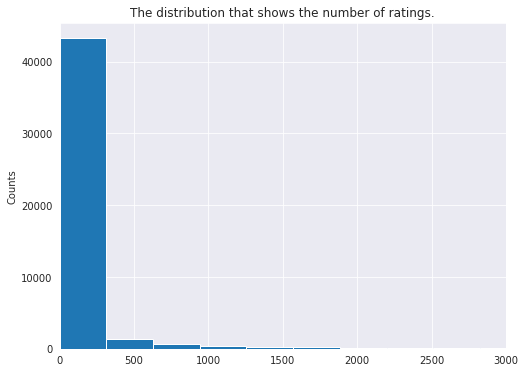

In [20]:
# histogram for the number of ratings
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')
%matplotlib inline

plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating_counts'].hist(bins=100)
plt.xlim([0,3000])
plt.title('The distribution that shows the number of ratings.')
plt.ylabel('Counts')
plt.show()

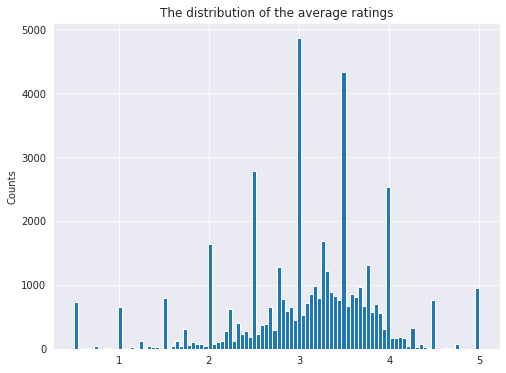

In [19]:
# histogram for average ratings
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating'].hist(bins=100)
plt.title('The distribution of the average ratings')
plt.ylabel('Counts')
plt.show()

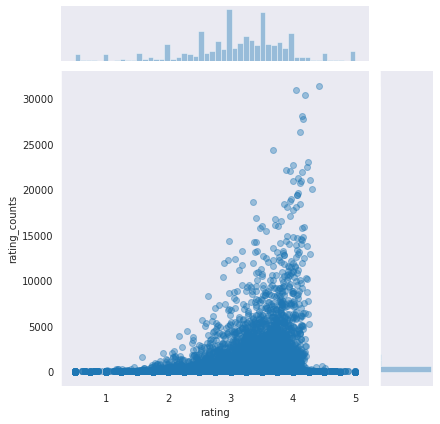

In [23]:
# average ratings against the number of ratings
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='rating', y='rating_counts', data=ratings_mean_count, alpha=0.4)
plt.show()

In [26]:
# retrieve movies similar to Shawshank Redemption by finding correlation
user_movie_rating = data[:500000].pivot_table(index='userId', columns='title', values='rating')
# this movie because it has the highest number of ratings
shawshank_ratings = user_movie_rating['Shawshank Redemption, The (1994)']
movies_like_shawshank = user_movie_rating.corrwith(shawshank_ratings)

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


In [27]:
corr_shawshank = pd.DataFrame(movies_like_shawshank, columns=['Correlation'])
corr_shawshank.dropna(inplace=True)
corr_shawshank.head()

,Correlation
title,
10 Cloverfield Lane (2016),0.134415
102 Dalmatians (2000),0.047783
1984 (1956),0.641586
"Abominable Dr. Phibes, The (1971)",0.172256
Airplane! (1980),0.139492


In [28]:
# Let's sort the movies in descending order of correlation to see highly correlated movies at the top
corr_shawshank.sort_values('Correlation', ascending=False).head(10)

,Correlation
title,
"Shawshank Redemption, The (1994)",1.000000
1984 (1956),0.641586
Blue Thunder (1983),0.360691
"Usual Suspects, The (1995)",0.354099
Toy Story That Time Forgot (2014),0.341695
Intouchables (2011),0.339549
"Pianist, The (2002)",0.302398
"Rock, The (1996)",0.271250
As Good as It Gets (1997),0.270459


In [29]:
# retrieve only those correlated movies that have at least more than 50 ratings
corr_shawshank = corr_shawshank.join(ratings_mean_count['rating_counts'])
corr_shawshank.head()

,Correlation,rating_counts
title,,
10 Cloverfield Lane (2016),0.134415,1388
102 Dalmatians (2000),0.047783,635
1984 (1956),0.641586,178
"Abominable Dr. Phibes, The (1971)",0.172256,185
Airplane! (1980),0.139492,7766


In [30]:
# filter movies correlated to "Shawshank Redemption, The (1994", that have more than 50 ratings
corr_shawshank[corr_shawshank['rating_counts']>50].sort_values('Correlation', ascending=False).head()

,Correlation,rating_counts
title,,
"Shawshank Redemption, The (1994)",1.000000,31380
1984 (1956),0.641586,178
Blue Thunder (1983),0.360691,77
"Usual Suspects, The (1995)",0.354099,21023
Toy Story That Time Forgot (2014),0.341695,90


#Modelling

A reader is needed in order to input `rating_scale` parameter

In [11]:
reader = Reader(rating_scale=(1, 5))

 - Load data into format that Surprise understands using Dataset class from surprise
 - The columns must correspond to user id, item id and ratings (in that order).

In [12]:
data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)

We can now use this dataset as we please, e.g. calling cross_validate

In [13]:
# we are using the full train dataset to train the model here - should use test and train split in order to evaluate
trainset = data.build_full_trainset()

## SVD model

In [14]:
# Build an algorithm, and train it.
algo = SVD()
algo.fit(trainset)

# Recommender predictions

Example on how to predict using the SVD algorithm

In [15]:
# raw user id (as in the ratings file). They are **strings**!
uid = str(1)
# raw item id (as in the ratings file). They are **strings**!
iid = str(2011)

Get a prediction for specific users and items.

In [16]:
pred = algo.predict(uid, iid, r_ui=4, verbose=True)

user: 1          item: 2011       r_ui = 4.00   est = 3.53   {'was_impossible': False}


Get a prediction for the test data

In [17]:
# Predict on our test data
predcol = []
for _, row in test_df.iterrows():
    x = (algo.predict(row.userId, row.movieId))
    pred = x[3]
    predcol.append(pred)

In [18]:
# check if the prediction length is the same as input length
len(predcol) == len(test_df)

True

In [19]:
# Convert columns to string in order to prep for concatenating
test_df['userId'] = test_df['userId'].astype(str)
test_df['movieId'] = test_df['movieId'].astype(str)

In [20]:
# Create submission column ID
test_df['Id'] =test_df['userId']+'_'+test_df['movieId']

In [21]:
kaggle_df = pd.DataFrame(
    {'Id': test_df['Id'],
     'rating': predcol
    })

In [22]:
kaggle_df.shape

(5087010, 2)

In [23]:
kaggle_df.head()

,Id,rating
0,1_2011,3.522908
1,1_4144,4.179861
2,1_5767,3.270738
3,1_6711,3.794051
4,1_7318,3.430872


In [24]:
# Export to csv
kaggle_df.to_csv("recommend_2.csv",index=False)

In [ ]:
# Comet logging

params = {"random_state": 'none',
          "model_type": "SVD",
          "scaler": "none",
          "param_grid": str(param_grid)
          }
metrics = {"RMSE": 'none',
           "top n": 'none',
           "MAE": 'none'
           }

# Log parameters and results
experiment.log_parameters(params)
experiment.log_metrics(metrics)

# End Experiment# Create dictionaries for comet

params = {"random_state": 'none',
          "model_type": "SVD",
          "scaler": "none",
          "param_grid": str(param_grid)
          }
metrics = {"RMSE": 'none',
           "top n": 'none',
           "MAE": 'none'
           }

# Log parameters and results
experiment.log_parameters(params)
experiment.log_metrics(metrics)

# End Experiment